# Import Libraries

In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-o33epyti
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-o33epyti
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.1 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=4f01dd1843a1a3ea1b9df19561cdb62d1afcc2d5c88335f93c6e3c5a9d5a6fe8
  Stored in directory: /tmp/pip-ephem-wheel-cache-_986m6fz/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
from sklearn.model_selection import train_test_split
from typing import Tuple, Optional
from accelerate import Accelerator
from PIL import Image, ImageFile
from tqdm import tqdm
import argparse
import json
import sys
import os

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import functional as nnf
from torch.utils.data import Dataset, DataLoader, ConcatDataset

In [4]:
from transformers import AutoTokenizer
from transformers import (
    GPT2LMHeadModel,
    AdamW,
    get_linear_schedule_with_warmup,
    set_seed,
)

In [5]:
import clip

# Load data and custom data

In [6]:
directory = "/kaggle/working/new_caption"

if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Thư mục '{directory}' đã được tạo.")
else:
    print(f"Thư mục '{directory}' đã tồn tại.")

Thư mục '/kaggle/working/new_caption' đã được tạo.


In [7]:
train_caption_path = "/kaggle/input/ktvic-dataset/ktvic/annotations/train_caption.json"  
test_caption_path = "/kaggle/input/ktvic-dataset/ktvic/annotations/test_caption.json"
out_train_path = "/kaggle/working/new_caption/train_caption.json"
out_test_path = "/kaggle/working/new_caption/test_caption.json"

In [8]:
with open(train_caption_path, 'r') as file:
    data = json.load(file)

images = {img['id']: img['filename'] for img in data['images']}
annotations = {}

for annotation in data['annotations']:
    image_id = annotation['image_id']
    caption = annotation['caption']
    
    filename = images.get(image_id)
    if filename not in annotations:
        annotations[filename] = []
    annotations[filename].append(caption)

result = [{"id": img_id, "captions": " .\n".join(captions)} for img_id, captions in annotations.items()]

with open(out_train_path, 'w') as output_file:
    json.dump(result, output_file, ensure_ascii=False, indent=4)

print(f"Dữ liệu đã được chuyển đổi và lưu vào file: {out_train_path}")


Dữ liệu đã được chuyển đổi và lưu vào file: /kaggle/working/new_caption/train_caption.json


In [9]:
with open(test_caption_path, 'r') as file:
    data = json.load(file)

images = {img['id']: img['filename'] for img in data['images']}
annotations = {}

for annotation in data['annotations']:
    image_id = annotation['image_id']
    caption = annotation['caption']
    
    filename = images.get(image_id)
    if filename not in annotations:
        annotations[filename] = []
    annotations[filename].append(caption)

result = [{"id": img_id, "captions": " .\n".join(captions)} for img_id, captions in annotations.items()]

with open(out_test_path, 'w') as output_file:
    json.dump(result, output_file, ensure_ascii=False, indent=4)

print(f"Dữ liệu đã được chuyển đổi và lưu vào file: {out_test_path}")


Dữ liệu đã được chuyển đổi và lưu vào file: /kaggle/working/new_caption/test_caption.json


# Encode Images

In [10]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

BATCH_SIZE = 64
MAX_TGT_SEQ_LEN = 128
VOCAB_SIZE = 50256

device = torch.device("cuda:0") if torch.cuda.is_available else torch.device("cpu")
vtokenizer = AutoTokenizer.from_pretrained("imthanhlv/gpt2news")
vtokenizer.pad_token = "<pad>"

config.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
clip_model, preprocess = clip.load("ViT-B/16", device=device)

100%|███████████████████████████████████████| 335M/335M [00:46<00:00, 7.51MiB/s]


In [12]:
def tokenize(text):
    return vtokenizer.encode(
        text, max_length=MAX_TGT_SEQ_LEN, truncation=True, padding="max_length"
    )


train_raw = json.load(open("/kaggle/working/new_caption/train_caption.json"))
train, val = train_test_split(train_raw, test_size=0.2, random_state=42)
test = json.load(open("/kaggle/working/new_caption/test_caption.json", "r"))

In [13]:
print(
    "Train images:", len(train), "| Validation images:", len(val), "| Test images:", len(test), "\n"
    "Train captions:", len(train)*5, "| Validation captions:", len(val)*5, "| Test captions:", len(test)*5,
)

Train images: 3015 | Validation images: 754 | Test images: 558 
Train captions: 15075 | Validation captions: 3770 | Test captions: 2790


In [14]:
def create_dataset(text_image_pairs, image_path, save_path):
    """
    Calculate CLIP embeddings for each image and save them to disk
    Args:
        text_image_pairs: list of tuples (text, image_path)
        image_path: path to the images
        save_path: path to save the embeddings
    """
    clip_embedding = []
    tgt = []
    ids = []
    with torch.no_grad():
        for batch in tqdm(DataLoader(text_image_pairs, batch_size=BATCH_SIZE)):
            images_path = [image_path + i for i in batch["id"]]
            images = torch.stack([preprocess(Image.open(i)) for i in images_path]).to(
                device
            )
            embeddings = clip_model.encode_image(images).cpu()
            if "captions" in batch:
                for embedding, captions, img_path in zip(
                    embeddings, batch["captions"], images_path
                ):
                    for caption in captions.split("\n"):
                        vt = tokenize(caption)
                        assert all(
                            [id <= VOCAB_SIZE for id in vt]
                        ), f"Must skip sentence with token ids > {VOCAB_SIZE}"
                        clip_embedding.append(embedding)
                        tgt.append(torch.LongTensor(vt))
                        ids.append(img_path)
    clip_embedding = torch.stack(clip_embedding)
    tgt = torch.stack(tgt)
    torch.save(
        {"clip_embedding": clip_embedding, "target": tgt, "id": ids},
        save_path,
    )
    print("Done")

In [15]:
directory = "/kaggle/working/embedding_images"

if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Thư mục '{directory}' đã được tạo.")
else:
    print(f"Thư mục '{directory}' đã tồn tại.")

Thư mục '/kaggle/working/embedding_images' đã được tạo.


In [16]:
directory = "/kaggle/working/embedding_images/ViT_B_16"

if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Thư mục '{directory}' đã được tạo.")
else:
    print(f"Thư mục '{directory}' đã tồn tại.")

Thư mục '/kaggle/working/embedding_images/ViT_B_16' đã được tạo.


In [17]:
create_dataset(train, "/kaggle/input/ktvic-dataset/ktvic/images/train/", "/kaggle/working/embedding_images/ViT_B_16/train_img.pt")
create_dataset(val, "/kaggle/input/ktvic-dataset/ktvic/images/train/", "/kaggle/working/embedding_images/ViT_B_16/val_img.pt")
create_dataset(test, "/kaggle/input/ktvic-dataset/ktvic/images/test/", "/kaggle/working/embedding_images/ViT_B_16/test_img.pt")

100%|██████████| 48/48 [01:21<00:00,  1.69s/it]


Done


100%|██████████| 12/12 [00:19<00:00,  1.65s/it]


Done


100%|██████████| 9/9 [00:14<00:00,  1.57s/it]

Done


# Encode caption

In [18]:
from datasets import Dataset
from datasets import load_dataset

In [19]:
dataset_path = "/kaggle/input/embedding/pytorch/default/2/iwslt2015-en-vi_mt_eng_vietnamese-test.parquet"

dataset = Dataset.from_parquet(dataset_path)
print(dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['translation'],
    num_rows: 1269
})


In [20]:
def norm(str):
    return (
        str.replace(" ,", ",")
        .replace(" .", ".")
        .replace(" :", ":")
        .replace("&quot;", '"')
        .replace(' "', '"')
        .replace("&apos;", "'")
        .replace(" '", "'")
    )

en_sentences = [
    norm(item["translation"]["en"])
    for item in dataset
    if (len(item["translation"]["en"].strip()) > 0 and len(item["translation"]["vi"].strip()) > 0)
]
vi_sentences = [
    norm(item["translation"]["vi"])
    for item in dataset
    if (len(item["translation"]["en"].strip()) > 0 and len(item["translation"]["vi"].strip()) > 0)
]

en_token = []
vi_token = []
skip = []


VOCAB_SIZE = 10000  
BATCH_SIZE = 32 
device = "cuda" if torch.cuda.is_available() else "cpu"

for en, vi in tqdm(zip(en_sentences, vi_sentences)):
    try:
        et = clip.tokenize([en])  # torch
        vt = tokenize(vi)  # array
        assert all([id <= VOCAB_SIZE for id in vt])
        en_token.append(et)
        vi_token.append(vt)

    except:
        skip.append(en)

print("Skip total", len(skip))

def collate_fn(batch):
    be = [i[0] for i in batch]
    bv = [i[1] for i in batch]
    return torch.cat(be), torch.tensor(bv)

dataloader = DataLoader(
    list(zip(en_token, vi_token)),
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    shuffle=True,
)

clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_embedding = []
tgt = []

with torch.no_grad():
    for et, vt in tqdm(dataloader):
        e_embed = clip_model.encode_text(et.to(device)).cpu()
        clip_embedding.append(e_embed)
        tgt.append(vt)

clip_embedding = torch.cat(clip_embedding)
tgt = torch.cat(tgt)
torch.save(
    {"clip_embedding": clip_embedding, "target": tgt},
    "/kaggle/working/embedding_images/ViT_B_16/text_b16.pt",
)


1268it [00:00, 1731.03it/s]


Skip total 409


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 115MiB/s]
100%|██████████| 27/27 [00:01<00:00, 23.30it/s]


# Clip Dataset

In [21]:
class ClipDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, prefix_length):
        data = torch.load(data_path)
        self.tokens = data["target"]  
        self.prefixes = data["clip_embedding"]  
        self.prefix_length = prefix_length
        self.masks = [torch.ones(len(token)) for token in self.tokens]

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        token = self.tokens[idx]
        mask = self.masks[idx]
        prefix = self.prefixes[idx].float()
        return token, mask, prefix

# Models

In [22]:
import torch
import torch.nn as nn
from transformers import (
    GPT2LMHeadModel,
    AdamW,
    get_linear_schedule_with_warmup,
    set_seed,
)
from tqdm import tqdm
from typing import Tuple, Optional
from accelerate import Accelerator


class MLP(nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        """Project clip output to embedding of first prefix_length tokens"""
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
                layers.append(nn.Dropout(p=0.2))
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):
    def get_dummy_token(self, batch_size: int, device: torch.device) -> torch.Tensor:
        """Generate prefix tokens, shape Bxprefix_length"""
        return torch.zeros(
            batch_size, self.prefix_length, dtype=torch.int64, device=device
        )

    def forward(
        self,
        tokens: torch.Tensor,
        prefix: torch.Tensor,
        mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
    ):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(
            -1, self.prefix_length, self.gpt_embedding_size
        )
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int = 10, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained("imthanhlv/gpt2news")
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        self.clip_project = MLP(
            (
                prefix_size,
                (self.gpt_embedding_size * prefix_length) // 2,
                self.gpt_embedding_size * prefix_length,
            )
        )


class ClipCaptionPrefix(ClipCaptionModel):
    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self



# Train

In [23]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_
from torch.cuda.amp import autocast

In [24]:
import os
import sys
import torch
import torch.nn.functional as nnf
from torch.utils.data import DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup, set_seed
from tqdm import tqdm
from accelerate import Accelerator
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau


from torch.optim import AdamW
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from transformers import set_seed

In [25]:
class Trainer:
    def __init__(self, model, train_dataset, val_dataset, config):
        self.accelerator = Accelerator()
        self.model = model
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.config = config
        
        self.train_dataloader = DataLoader(
            train_dataset,
            batch_size=config["batch_size"],
            shuffle=True,
            drop_last=True,
            collate_fn=self.collate_fn,
        )
        self.val_dataloader = DataLoader(
            val_dataset,
            batch_size=config["batch_size"],
            shuffle=False,
            drop_last=False,
            collate_fn=self.collate_fn,
        )
        self.optimizer = AdamW(model.parameters(), lr=config["lr"])
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", factor=0.1, patience=1)
        self.early_stopping_patience = config.get("early_stopping_patience", 3)
        self.best_val_loss = float("inf")
        self.best_epoch = -1
        self.epochs_no_improve = 0
        
        self.train_losses = []
        self.val_losses = []
        self.learning_rates = []
        
        self.output_dir = config.get("output_dir", "checkpoints")
        os.makedirs(self.output_dir, exist_ok=True)

        self.model, self.optimizer, self.train_dataloader, self.val_dataloader = self.accelerator.prepare(
            model, self.optimizer, self.train_dataloader, self.val_dataloader
        )

    def collate_fn(self, batch):
        tokens, masks, prefixes = zip(*batch)
        tokens = torch.nn.utils.rnn.pad_sequence(tokens, batch_first=True, padding_value=0).float()
        masks = torch.nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0).float()
        prefixes = torch.stack(prefixes).float()
        return tokens, masks, prefixes

    def train(self):
        set_seed(self.config["seed"])
        for epoch in range(self.config["epochs"]):
            print(f"Epoch {epoch+1}/{self.config['epochs']}")
            
            train_loss = self.train_one_epoch()
            val_loss = self.validate()

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.learning_rates.append(self.optimizer.param_groups[0]["lr"])

            self.scheduler.step(val_loss)

            if val_loss < self.best_val_loss:
                print(f"Validation loss improved from {self.best_val_loss:.4f} to {val_loss:.4f}. Saving model.")
                self.best_val_loss = val_loss
                self.best_epoch = epoch
                self.epochs_no_improve = 0
                self.save_checkpoint(epoch, best=True)
            else:
                print(f"Validation loss did not improve. Best loss: {self.best_val_loss:.4f}.")
                self.epochs_no_improve += 1

            print(f"Training Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f} | Learning rate: {self.optimizer.param_groups[0]['lr']:.6f}")

            if self.epochs_no_improve >= self.early_stopping_patience:
                print("Early stopping triggered.")
                break

        print(f"Training finished. Best model at epoch {self.best_epoch + 1} with val_loss {self.best_val_loss:.4f}")

    def train_one_epoch(self):
        self.model.train()
        total_loss = 0
        progress = tqdm(self.train_dataloader, desc="Training", leave=False)
        for tokens, masks, prefixes in progress:
            tokens = tokens.to(self.accelerator.device, dtype=torch.long)
            masks = masks.to(self.accelerator.device, dtype=torch.float32)
            prefixes = prefixes.to(self.accelerator.device, dtype=torch.float32)

            outputs = self.model(tokens, prefixes, masks)
            logits = outputs.logits[:, self.config["prefix_length"] - 1 : -1]
            loss = nnf.cross_entropy(
                logits.reshape(-1, logits.shape[-1]), tokens.flatten(), ignore_index=0
            )

            self.accelerator.backward(loss)
            clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.optimizer.zero_grad()

            total_loss += loss.item()
            progress.set_postfix({"loss": loss.item()})

        return total_loss / len(self.train_dataloader)

    def validate(self):
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for tokens, masks, prefixes in tqdm(self.val_dataloader, desc="Validating", leave=False):
                tokens = tokens.to(self.accelerator.device, dtype=torch.long)
                masks = masks.to(self.accelerator.device, dtype=torch.float32)
                prefixes = prefixes.to(self.accelerator.device, dtype=torch.float32)

                outputs = self.model(tokens, prefixes, masks)
                logits = outputs.logits[:, self.config["prefix_length"] - 1 : -1]
                loss = nnf.cross_entropy(
                    logits.reshape(-1, logits.shape[-1]), tokens.flatten(), ignore_index=0
                )
                total_loss += loss.item()

        return total_loss / len(self.val_dataloader)

    def save_checkpoint(self, epoch, best=False):
        checkpoint_name = "best_model.pt" if best else f"model_epoch_{epoch + 1}.pt"
        save_path = os.path.join(self.output_dir, checkpoint_name)
        self.accelerator.save(self.model.state_dict(), save_path)

    def plot_metrics(self):
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label="Train Loss", marker='o')
        plt.plot(self.val_losses, label="Validation Loss", marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Loss per Epoch")

        plt.subplot(1, 2, 2)
        plt.plot(self.learning_rates, label="Learning Rate", marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.legend()
        plt.title("Learning Rate per Epoch")

        plt.tight_layout()
        plt.show()

In [26]:
import matplotlib.pyplot as plt

In [27]:
config = {
    "epochs": 50,
    "lr": 1e-6,
    "seed": 42,
    "batch_size": 16,
    "prefix_length": 10,
    "early_stopping_patience": 3,
    "output_dir": "/kaggle/working/checkpoints",
}

train_dataset = ConcatDataset(
        (
            ClipDataset("/kaggle/working/embedding_images/ViT_B_16/text_b16.pt", config["prefix_length"]),
            ClipDataset("/kaggle/working/embedding_images/ViT_B_16/train_img.pt", config["prefix_length"]),
        )
    )
# train_dataset = ClipDataset("/kaggle/working/embedding_images/ViT_B_16/train_img.pt", config["prefix_length"])
val_dataset = ClipDataset("/kaggle/working/embedding_images/ViT_B_16/val_img.pt", config["prefix_length"])
model = ClipCaptionModel(config["prefix_length"])

<ipython-input-21-855761c0a673>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)


pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

In [28]:
import time
start_time = time.time()

trainer = Trainer(model, train_dataset, val_dataset, config)
trainer.train()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Thời gian huấn luyện: {elapsed_time:.2f} giây")

Epoch 1/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from inf to 7.3577. Saving model.
Training Loss: 9.9521 | Validation Loss: 7.3577 | Learning rate: 0.000001
Epoch 2/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 7.3577 to 4.8016. Saving model.
Training Loss: 5.9963 | Validation Loss: 4.8016 | Learning rate: 0.000001
Epoch 3/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 4.8016 to 3.5303. Saving model.
Training Loss: 4.2366 | Validation Loss: 3.5303 | Learning rate: 0.000001
Epoch 4/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 3.5303 to 2.5402. Saving model.
Training Loss: 3.0991 | Validation Loss: 2.5402 | Learning rate: 0.000001
Epoch 5/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 2.5402 to 1.6944. Saving model.
Training Loss: 2.1629 | Validation Loss: 1.6944 | Learning rate: 0.000001
Epoch 6/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 1.6944 to 1.0253. Saving model.
Training Loss: 1.3849 | Validation Loss: 1.0253 | Learning rate: 0.000001
Epoch 7/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 1.0253 to 0.5896. Saving model.
Training Loss: 0.8188 | Validation Loss: 0.5896 | Learning rate: 0.000001
Epoch 8/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.5896 to 0.3640. Saving model.
Training Loss: 0.4867 | Validation Loss: 0.3640 | Learning rate: 0.000001
Epoch 9/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.3640 to 0.2676. Saving model.
Training Loss: 0.3283 | Validation Loss: 0.2676 | Learning rate: 0.000001
Epoch 10/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.2676 to 0.2302. Saving model.
Training Loss: 0.2627 | Validation Loss: 0.2302 | Learning rate: 0.000001
Epoch 11/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.2302 to 0.2163. Saving model.
Training Loss: 0.2365 | Validation Loss: 0.2163 | Learning rate: 0.000001
Epoch 12/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.2163 to 0.2094. Saving model.
Training Loss: 0.2255 | Validation Loss: 0.2094 | Learning rate: 0.000001
Epoch 13/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.2094 to 0.2049. Saving model.
Training Loss: 0.2186 | Validation Loss: 0.2049 | Learning rate: 0.000001
Epoch 14/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.2049 to 0.2009. Saving model.
Training Loss: 0.2132 | Validation Loss: 0.2009 | Learning rate: 0.000001
Epoch 15/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.2009 to 0.1977. Saving model.
Training Loss: 0.2088 | Validation Loss: 0.1977 | Learning rate: 0.000001
Epoch 16/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.1977 to 0.1952. Saving model.
Training Loss: 0.2051 | Validation Loss: 0.1952 | Learning rate: 0.000001
Epoch 17/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.1952 to 0.1931. Saving model.
Training Loss: 0.2019 | Validation Loss: 0.1931 | Learning rate: 0.000001
Epoch 18/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.1931 to 0.1916. Saving model.
Training Loss: 0.1992 | Validation Loss: 0.1916 | Learning rate: 0.000001
Epoch 19/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.1916 to 0.1902. Saving model.
Training Loss: 0.1969 | Validation Loss: 0.1902 | Learning rate: 0.000001
Epoch 20/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.1902 to 0.1889. Saving model.
Training Loss: 0.1945 | Validation Loss: 0.1889 | Learning rate: 0.000001
Epoch 21/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.1889 to 0.1882. Saving model.
Training Loss: 0.1927 | Validation Loss: 0.1882 | Learning rate: 0.000001
Epoch 22/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.1882 to 0.1872. Saving model.
Training Loss: 0.1908 | Validation Loss: 0.1872 | Learning rate: 0.000001
Epoch 23/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.1872 to 0.1863. Saving model.
Training Loss: 0.1892 | Validation Loss: 0.1863 | Learning rate: 0.000001
Epoch 24/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.1863 to 0.1859. Saving model.
Training Loss: 0.1875 | Validation Loss: 0.1859 | Learning rate: 0.000001
Epoch 25/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.1859 to 0.1855. Saving model.
Training Loss: 0.1859 | Validation Loss: 0.1855 | Learning rate: 0.000001
Epoch 26/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.1855 to 0.1847. Saving model.
Training Loss: 0.1844 | Validation Loss: 0.1847 | Learning rate: 0.000001
Epoch 27/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.1847 to 0.1845. Saving model.
Training Loss: 0.1830 | Validation Loss: 0.1845 | Learning rate: 0.000001
Epoch 28/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.1845 to 0.1839. Saving model.
Training Loss: 0.1817 | Validation Loss: 0.1839 | Learning rate: 0.000001
Epoch 29/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.1839 to 0.1831. Saving model.
Training Loss: 0.1803 | Validation Loss: 0.1831 | Learning rate: 0.000001
Epoch 30/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss did not improve. Best loss: 0.1831.
Training Loss: 0.1790 | Validation Loss: 0.1832 | Learning rate: 0.000001
Epoch 31/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.1831 to 0.1825. Saving model.
Training Loss: 0.1778 | Validation Loss: 0.1825 | Learning rate: 0.000001
Epoch 32/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.1825 to 0.1823. Saving model.
Training Loss: 0.1767 | Validation Loss: 0.1823 | Learning rate: 0.000001
Epoch 33/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss did not improve. Best loss: 0.1823.
Training Loss: 0.1755 | Validation Loss: 0.1823 | Learning rate: 0.000001
Epoch 34/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.1823 to 0.1823. Saving model.
Training Loss: 0.1743 | Validation Loss: 0.1823 | Learning rate: 0.000001
Epoch 35/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.1823 to 0.1814. Saving model.
Training Loss: 0.1732 | Validation Loss: 0.1814 | Learning rate: 0.000001
Epoch 36/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss did not improve. Best loss: 0.1814.
Training Loss: 0.1720 | Validation Loss: 0.1820 | Learning rate: 0.000001
Epoch 37/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss improved from 0.1814 to 0.1814. Saving model.
Training Loss: 0.1712 | Validation Loss: 0.1814 | Learning rate: 0.000001
Epoch 38/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss did not improve. Best loss: 0.1814.
Training Loss: 0.1699 | Validation Loss: 0.1820 | Learning rate: 0.000001
Epoch 39/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss did not improve. Best loss: 0.1814.
Training Loss: 0.1689 | Validation Loss: 0.1816 | Learning rate: 0.000000
Epoch 40/50


Training:   0%|          | 0/995 [00:00<?, ?it/s]

Validating:   0%|          | 0/236 [00:00<?, ?it/s]

Validation loss did not improve. Best loss: 0.1814.
Training Loss: 0.1675 | Validation Loss: 0.1816 | Learning rate: 0.000000
Early stopping triggered.
Training finished. Best model at epoch 37 with val_loss 0.1814
Thời gian huấn luyện: 13770.98 giây


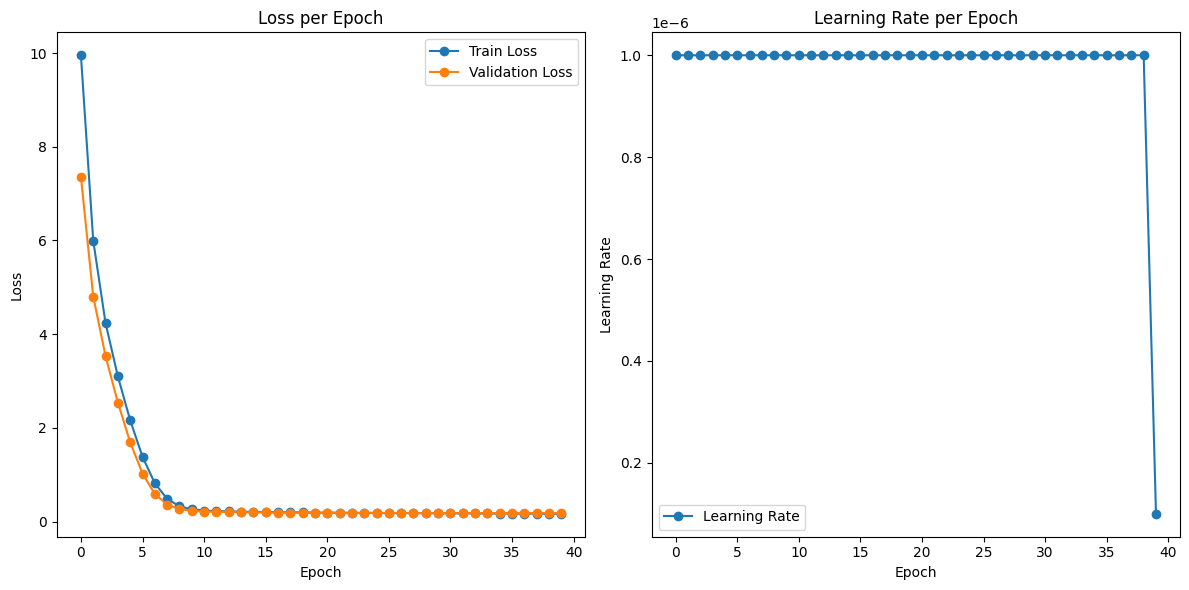

In [29]:
trainer.plot_metrics()